<a href="https://colab.research.google.com/github/aniketmaurya/talks/blob/main/2021-06-27%20PyTorch%20Lightning/01%20pytorch-to-lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch --> PyTorch Lightning

## Image Classification with PyTorch

In [2]:
# !pip install -U pytorch-lightning -q

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

In [6]:
train_data = torchvision.datasets.CIFAR10('/Users/aniket/datasets/',
                                          download=True,
                                          transform=transform)

val_data = torchvision.datasets.CIFAR10('/Users/aniket/datasets/',
                                        train=False,
                                        download=True,
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=batch_size,
                                        shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')


Extracting /Users/aniket/datasets/cifar-10-python.tar.gz to /Users/aniket/datasets/
Files already downloaded and verified


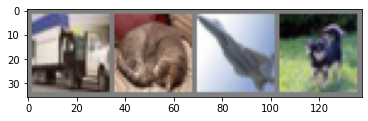

truck   cat plane   dog


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Load Model

In [8]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define Loss & Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
NUM_EPOCHS = 1

## Training Step

In [11]:
# Calculate loss
def train_step(model, data):
    inputs, labels = data

    y_pred = net(inputs)
    loss = criterion(y_pred, labels)
    return loss

# Training Loop 

In [12]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        loss = train_step(net, data)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.914
[1,  4000] loss: 1.590
[1,  6000] loss: 1.496
[1,  8000] loss: 1.446
[1, 10000] loss: 1.400
[1, 12000] loss: 1.373
Finished Training


https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

# ⚡️ PyTorch Lightning 

## Lightning Design Philosophy

![Design Phil](https://camo.githubusercontent.com/a3dda9b3053f7093ac1ccc30b41c0f367b171010770252528c30551a2407cad5/68747470733a2f2f706c2d626f6c74732d646f632d696d616765732e73332e75732d656173742d322e616d617a6f6e6177732e636f6d2f7068696c6f736f70686965732e6a7067)

In [13]:
import pytorch_lightning as pl

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [14]:
class LitModel(pl.LightningModule):

    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = Net()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        y_pred = self(inputs)
        loss = criterion(y_pred, labels)
        
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        y_pred = self(inputs)
        loss = criterion(y_pred, labels)
        
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams['lr'])
        return optimizer

In [15]:
class CIFARDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64):
        super().__init__()
        self.batch_size = batch_size
        
        self.train_data = torchvision.datasets.CIFAR10(
            '/Users/aniket/datasets/', download=True, transform=transform)

        self.val_data = torchvision.datasets.CIFAR10('/Users/aniket/datasets/',
                                                     train=False,
                                                     download=True,
                                                     transform=transform)
        

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data,
                                           batch_size=self.batch_size,
                                           shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data,
                                           batch_size=self.batch_size,
                                           shuffle=False)
    
cifar_dm = CIFARDataModule(batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


# Logger & Callbacks

In [19]:
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

tb_logger = TensorBoardLogger("tb_logs", name="lightning-demo")
csv_logger = CSVLogger('lightning-demo')

In [20]:
lit_model = LitModel(1e-3)
trainer = pl.Trainer(logger=[tb_logger, csv_logger])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(lit_model, datamodule=cifar_dm)


  | Name  | Type | Params
-------------------------------
0 | model | Net  | 62.0 K
-------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


#### References:
1. [PyTorch: TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
